In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import gc
from sklearn.preprocessing import RobustScaler

General functions

In [2]:
def loadData(doTest):
    ''' Load in the dataset'''
    
    if doTest == True:
        filepath = "data/test_set_VU_DM.csv"
    else:
        filepath = "data/training_set_VU_DM.csv"

    df = pd.read_csv(filepath, index_col=False)
    
    return df

def makeSmall(df, perc, doTest):
    if doTest == False:
        search_ids = df['srch_id'].unique()
        sampled_search_ids = np.random.choice(df, size = int(perc*len(search_ids)), replace=True)
        df = df.loc[np.isin(df['srch_id'], sampled_search_ids)]
        print("lala")

def dropTrainingOnlyData(df, doTest):
    ''' Training set only: drop columns position & gross_bookings_usd as they are not present for test '''
    if doTest == False:
        df = df.drop(["position", "gross_bookings_usd"], axis=1)
    return df

def printInformationData(df):
    ''' Print very small summary of data'''
    search_ids = df.srch_id.unique()
    print(f'There are {len(search_ids)} searches in the  set and {len(df)} data points')
    print(f'There are {len(df.srch_id.unique())} searches in the smaller training set and {len(df)} data points\n')
    
def plot_missing(data):
    missing = (data.isna().sum()/data.shape[0]*100) # missing percentages

    # plot missing 
    plt.figure(figsize=(20,10))
    missing.sort_values().plot(kind='bar')
    plt.title('Missing value % per Variables')
    
    return missing

def aggregate_competitor_info(df):
    df["agg_comp_rate"] = df.filter(regex=("comp.*rate$")).mean(axis=1)
    df["agg_comp_perc"] = df.filter(regex=("comp.*rate_perc")).mean(axis=1)
    df["agg_comp_inv"] = df.filter(regex=("comp.*inv")).mean(axis=1)
    return df.loc[:,~df.columns.str.startswith('comp')]
    
def impute(impute):

    # hotel properties: impute with worst case scenario. Stolen from #2 and #3
    impute[['prop_review_score', 'prop_location_score2']] = impute[['prop_review_score','prop_location_score2']].fillna(0)

    # set missing original distances to max() for each searchquery and -1 if no info
    impute[['srch_id','orig_destination_distance']].fillna(impute[['srch_id','orig_destination_distance']].groupby('srch_id').transform('max').squeeze(), inplace=True)
    impute.orig_destination_distance.fillna(-1, inplace=True) 
    
    # competitor info: aggregate with mean w.r.t searchquery and otherwise 0
    impute[['srch_id','agg_comp_rate']].fillna(impute[['srch_id','agg_comp_rate']].groupby('srch_id').transform('mean').squeeze(), inplace=True)
    impute[['srch_id','agg_comp_perc']].fillna(impute[['srch_id','agg_comp_perc']].groupby('srch_id').transform('mean').squeeze(), inplace=True)
    impute[['srch_id','agg_comp_inv']].fillna(impute[['srch_id','agg_comp_inv']].groupby('srch_id').transform('mean').squeeze(), inplace=True)
    impute[['agg_comp_rate','agg_comp_perc', 'agg_comp_inv']] = impute[['agg_comp_rate','agg_comp_perc', 'agg_comp_inv']].fillna(0) 

def normalise(df, column):
    df[column] = df.groupby('srch_id')[column].apply(lambda x: (x - x.mean()) / x.std())
    
def normaliseRobustScaler(df, columns):
    scaler = RobustScaler() 
    df[columns] = scaler.fit_transform(df[columns])

def add_grouped_numerical_info(df, group, column):

    # add mean/std/median information for this property

    if group == 'prop_id' or column == 'prop_location_score2' or (group == 'srch_id' and column=='price_usd'):
            
        df[column+"_"+group+"_mean"] = df.groupby(group)[column].transform("mean")
        
    if group == 'srch_id' or column == 'prop_location_score2' or (group == 'prop_id' and column=='price_usd'):
        df[column+"_"+group+"_std"] = df.groupby(group)[column].transform("std")
        
    if np.isin(column, ['prop_location_score2', 'price_usd']) or (group == 'prop_id' and column=='prop_location_score1'):
        df[column+"_"+group+"_median"] = df.groupby(group)[column].transform("median")
    
def makeTarget(df, doTest):
    if doTest == False:
        df['target'] = np.where(df.click_bool == 1, 1, 0)
        df['target'] = np.where(df.booking_bool == 1, 5, df.target)

        df.loc[:,['target', 'click_bool', 'booking_bool']].head(n=20)
    
def writeCsv(df, doTest):
    if doTest == False:
        df.to_csv("data/dummy/train.csv", index=False)
    else:
        df.to_csv("data/dummy/test.csv", index=False)
        
def processData(doTest):
    ''' Do the following:
        1. Load in dataset
        2. Drop columns present only in training set 
        3. Aggregate competitor information
        4. Remove columns with > 90% missing values
        5. Impute missing values
        6. Normalise
        7. Add statistical information of properties
        8. Add target column 
    '''
    
    # Load
    df = loadData(doTest)
    
    # Trop training only
    df = dropTrainingOnlyData(df, doTest)

    # Make training set smaller
    #makeSmall(df, 0.5, doTest)
    
    # Print summary
    printInformationData(df)
    missing = plot_missing(df)
    del missing
    gc.collect()
    
    # Aggregate competitor information 
    df = aggregate_competitor_info(df)
    missing = plot_missing(df)
    
    # Remove columns > 0.9 missing
    discard = missing[missing>90]
    print(discard)
    df.drop(discard.index, axis=1, inplace=True)
    missing = plot_missing(df)
    del missing
    gc.collect()
    
    # Impute missing values
    impute(df)
    missing = plot_missing(df)
    del missing
    gc.collect()
    
    #return df

    #normaliseRobustScaler(df, ['prop_location_score1', 'prop_location_score2'])
    #df['prop_location_score'] = df.loc[: , ['prop_location_score1', 'prop_location_score2']].mean(axis=1)
    
#def test(df, doTest):
    # Add property information
    numerical_columns = ['price_usd','prop_starrating','prop_review_score','prop_location_score1', 'prop_location_score2']
    groupby_columns = ['prop_id', 'srch_id', 'srch_destination_id']

    for group in groupby_columns:
        for numerical in numerical_columns:
            add_grouped_numerical_info(df, group, numerical)
            
    #df['prop_log_historical_price'] = df['prop_log_historical_price']**2
    
    # Normalise and combine prop_location scores 

    #df.drop(['prop_location_score1', 'prop_location_score2'], axis=1, inplace=True)

    # Make target
    makeTarget(df, doTest)
    
    # Write to csv
    writeCsv(df, doTest)
    
    return df


There are 199795 searches in the  set and 4958347 data points
There are 199795 searches in the smaller training set and 4958347 data points

visitor_hist_starrating      94.920364
visitor_hist_adr_usd         94.897735
srch_query_affinity_score    93.598552
dtype: float64


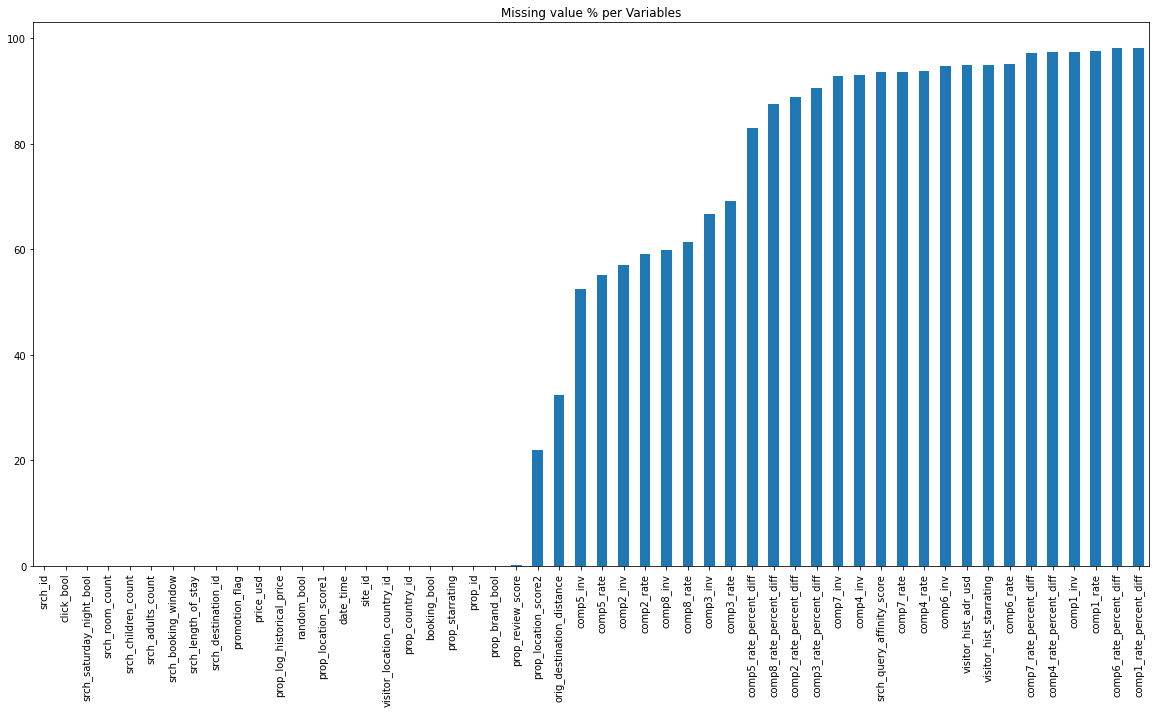

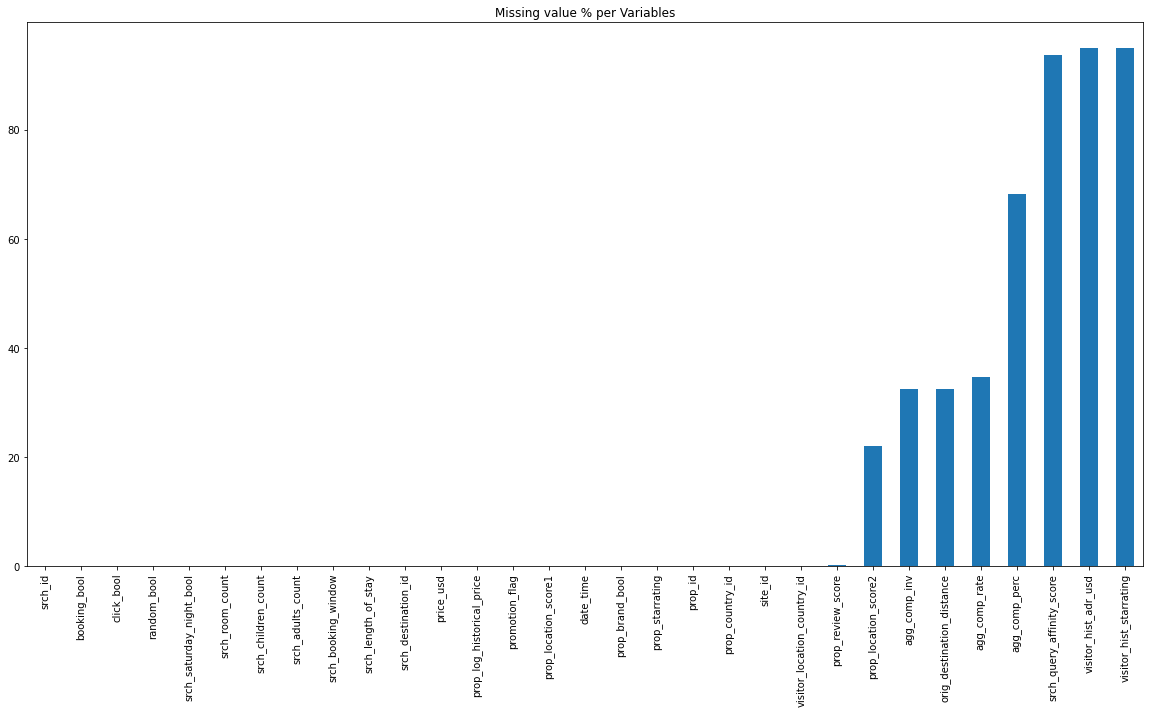

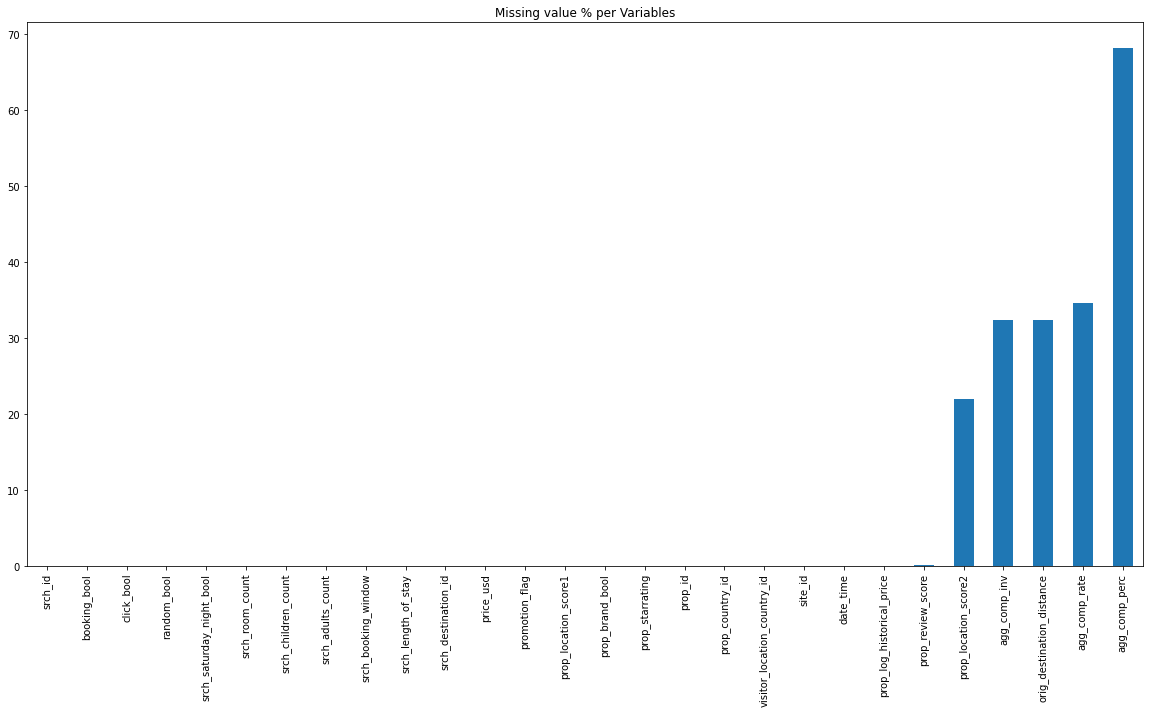

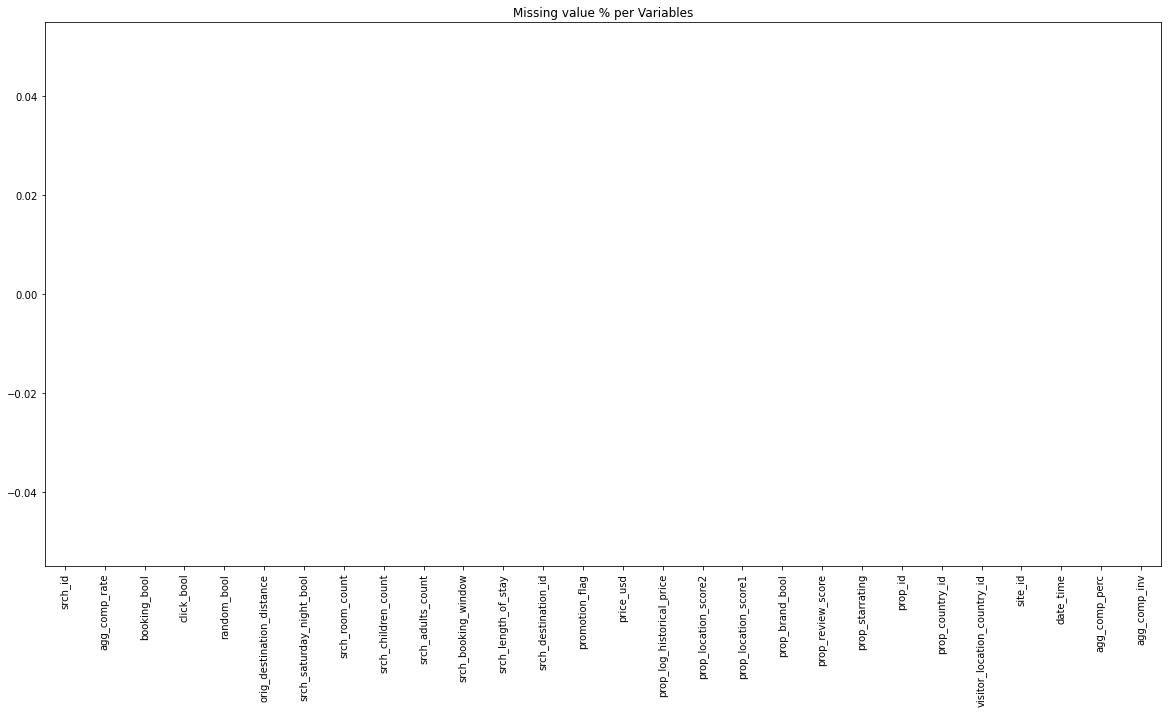

In [3]:
df = processData(False)

In [4]:
del df
gc.collect()

27549

There are 199549 searches in the  set and 4959183 data points
There are 199549 searches in the smaller training set and 4959183 data points

visitor_hist_starrating      94.889662
visitor_hist_adr_usd         94.865606
srch_query_affinity_score    93.584467
dtype: float64


0

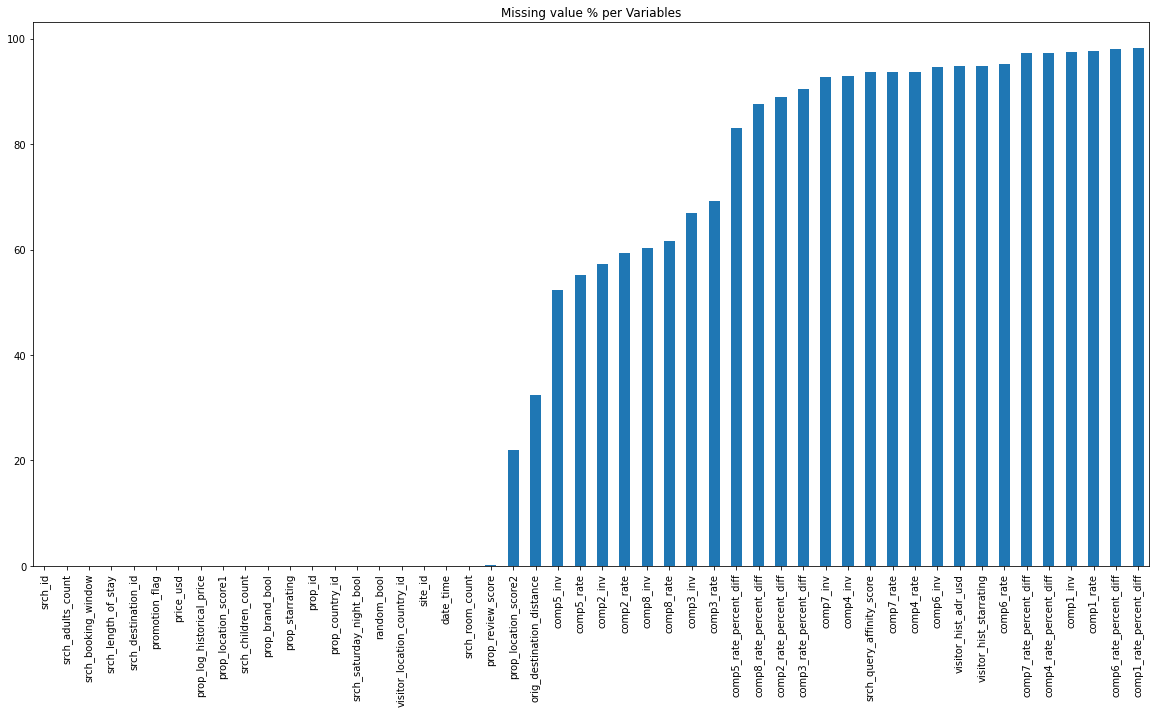

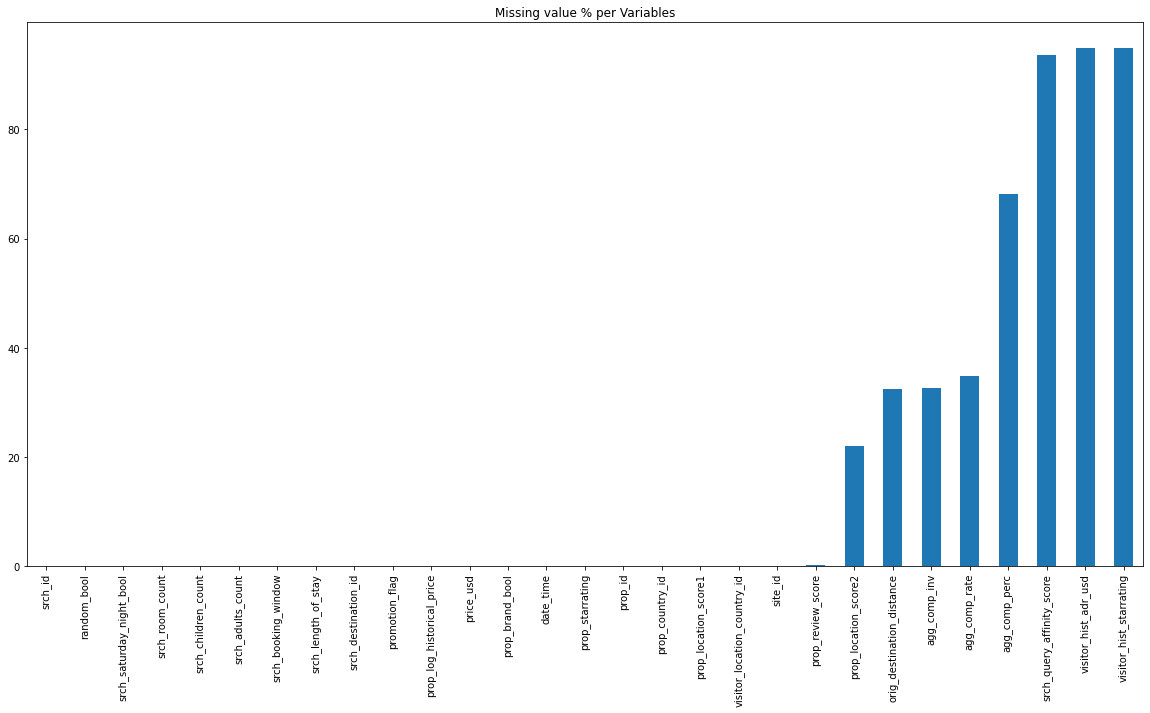

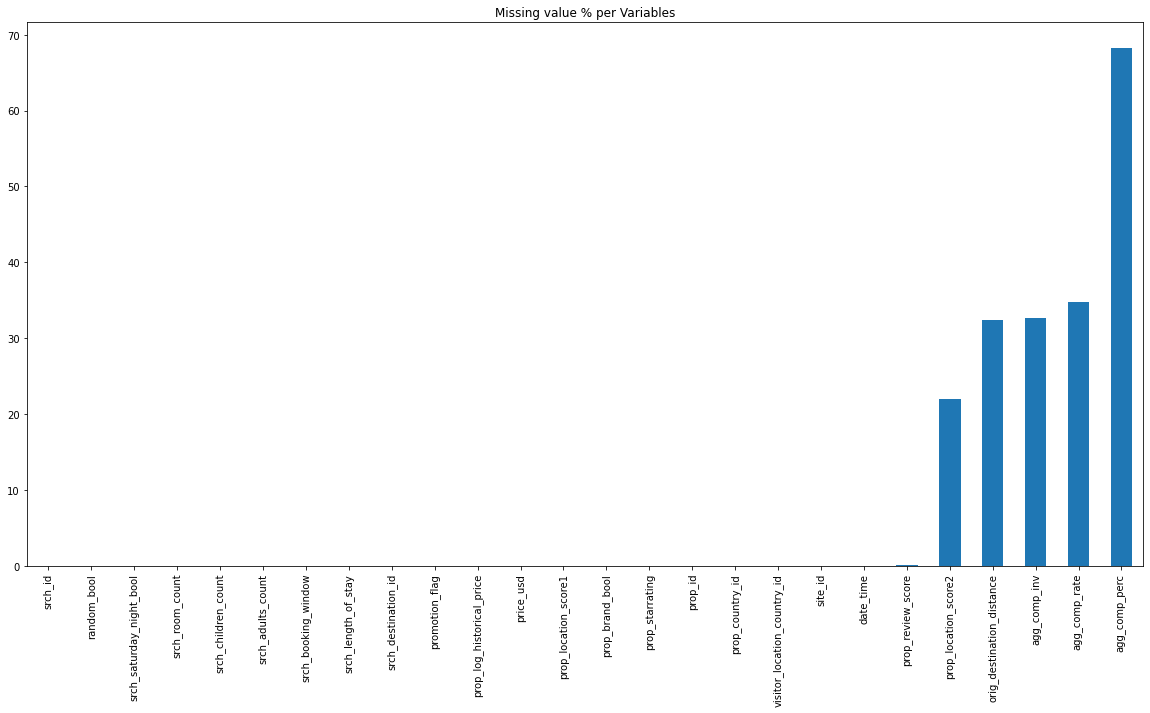

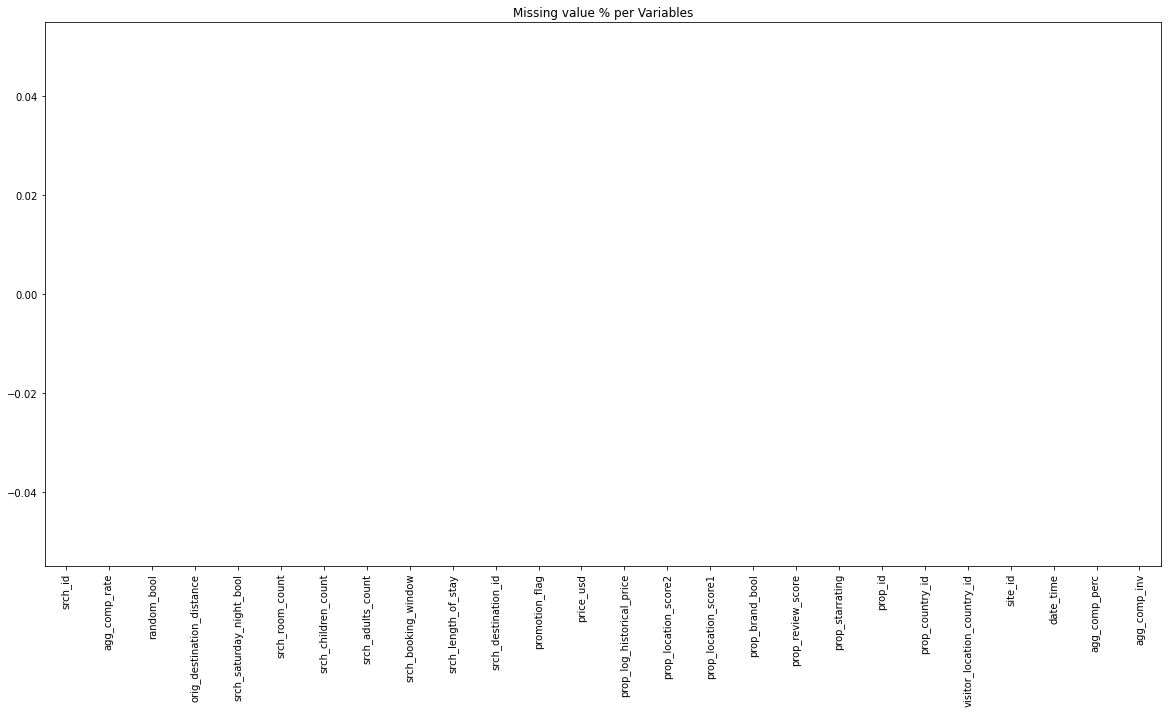

In [5]:
df = processData(True)
del df
gc.collect()

In [6]:
#pd.set_option('display.max_columns', None)
#df.describe()

In [7]:
#df.head(n=5)

Normalise